#### Traditional flow:
    1. Build a ANN
    2. Train it on test set
    3. Give an image as input and netowrk will predict the output.

#### Ensemble Learning:
    1. Build a ANN.
    2. Make mulitple copies of ANN(in this example 5)
    3. Train each ANN individual of others.
    4. Give the same image to all copies of ANN and each ann will have its own prediction.
    
Suppose say there are n copies of the same network. we end up with n predictions from these n different copies for 1 image. How we make a final decision depends on the value of n.

* If value of n is large, the value which most of the networks predicted is the final output.

* If the value of n is small, we take a mean of these predictions and calcualte argmax to extract the class

eg. for a particlar image from mnist dataset, the output from 5 different networks are:

**[0.1  0.0  0.0  0.1  0.0  0.3  0.0  0.5  0.1  0.0  0.0]** argmax => predicted class = 7

**[0.0  0.1  0.2  0.1  0.0  0.1  0.0  0.5  0.0  0.0  0.0]** argmax => predicted class = 7

**[0.6  0.1  0.0  0.1  0.0  0.2  0.0  0.0  0.0  0.0  0.0]** argmax => predicted class = 0

**[0.1  0.0  0.0  0.1  0.0  0.3  0.0  0.4  0.1  0.0  0.0]** argmax => predicted class = 7

**[0.1  0.0  0.0  0.1  0.0  0.3  0.0  0.5  0.1  0.0  0.0]** argmax => predicted class = 7

the mean of predictions looks like:

**[0.18  0.04  0.08  0.10  0.12  0.12  0.18  0.38  0.06  0.00]** argmax => class = 7

this is how the following example calculates predictions for ensemle network.

Note that ensemble network need not be better than the best perfomring network in our bag of ensembles.


In [2]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Helper Class for data handling


In [26]:
class Data():
    def __init__(self):
        self.size = 0

    def get_xdata(self,x_data_path):
        df = pd.read_csv(x_data_path, sep=',', header=None)
        a = np.array(df).astype(int)
        self.size = len(df)
        a = a.reshape(self.size,28,28)
        self.x_data = a
        return self.x_data

    def get_ydata(self,y_data_path):
        df = pd.read_csv(y_data_path,sep = ',',header = None)
        b = np.array(df).astype(int)
        b = b.reshape(len(df),10)
        self.y_data = b
        return self.y_data

    def get_rand_batch(self,batch_size = None):
        if batch_size is None:
            b_size = 128
        else:
            b_size = batch_size

        rand_indices = np.random.choice(self.size, b_size, replace=False)
        x_batch = self.x_data[rand_indices]
        self.x_batch = x_batch.reshape(b_size, 28, 28, 1)
        self.y_batch = self.y_data[rand_indices]

In [4]:
%%capture
train_data = Data()
train_data.get_xdata("data/x_train.csv")
train_data.get_ydata("data/y_train.csv")

(-0.5, 27.5, 27.5, -0.5)

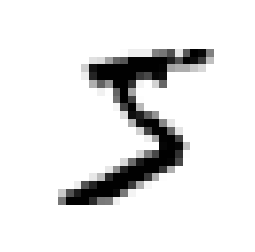

In [5]:
img = train_data.x_data[0].reshape(28,28)
plt.imshow(img,cmap = 'binary')
plt.axis("off")


### Helper function to plot images and  show the true label, predicted,ensembled label on the bottom
adapted from Hvass laboratories

In [6]:
def plot_images(images,y_true_cls,y_pred_cls = None,y_ensemb_cls = None):
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if y_ensemb_cls is None:
        hspace = 1
    else:
        hspace = 1.0
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # For each of the sub-plots.
    for i, ax in enumerate(axes.flat):

        # There may not be enough images for all sub-plots.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i].reshape(28,28), cmap='binary')

            # Show true and predicted classes.
            if (y_ensemb_cls is None):
                if (y_pred_cls is None):
                    xlabel = "True: {0}".format(y_true_cls[i])
                else:
                    msg = "True: {0} \nPredicted: {1}"
                    xlabel = msg.format(y_true_cls[i],y_pred_cls[i])
            else:
                msg = "True: {0}\nNetwork: {1}\nEnsemble: {2}"
                xlabel = msg.format(y_true_cls[i],y_pred_cls[i],y_ensemb_cls[i])

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Now we will define our compuational graph


![alt](https://github.com/thubatilakshmi/Ensemble-Learning/blob/master/network.JPG)

Placeholders for input to graph

In [27]:
x = tf.placeholder('float',shape = [None,28,28,1],name = "x")
y_true = tf.placeholder('float',shape = [None,10],name = "y_true")

In [28]:
y_true_cls = tf.argmax(y_true,axis = 1)

#### declaring initializers for kernels and biases

In [29]:
kern_init = tf.random_normal_initializer(mean = 0.0, stddev = 0.01)
bias_init = tf.zeros_initializer()

#### hyper parameters of graph
    1. The no. of convolution layers
    2. No. of kernel units in each convolution layer
    3. The window size of each kernels in each layer.
    4. No biases in conv layers.


In [30]:
ls_kern_count = [16,32,128,10]
# only the first 2 layers are conv2d, 128 and 10 are fully connected layers.
kern_size = [[5,5],[7,7]]

In [31]:
conv1 = tf.layers.conv2d(x,filters = ls_kern_count[0],
                        kernel_size=kern_size[0],
                        strides = [2,2],
                        padding ="same",
                        activation = tf.nn.relu,
                        use_bias = False,
                        kernel_initializer=kern_init,
                        trainable=True,name = "conv1")

In [32]:
conv2 = tf.layers.conv2d(conv1,filters=ls_kern_count[1],
                        kernel_size=kern_size[1],
                        strides=[2, 2], 
                        padding="same", 
                        activation=tf.nn.relu, 
                        use_bias=False,
                        kernel_initializer=kern_init, 
                        trainable=True,name = "conv2")

#### After 2 conv layers the input will be a 4 dimensional tensor, we flatten this out using tf.layers.flatten method,

Good thing about using tf.layers api is that we donot need to keep track of output tensor size after each convolution layer, the layers API will take care of it.

Without layers api when we are defining the dimensions of weight matrix for first fully connected layers we have to calculate the out put tensor dimensions.

In [33]:
flat_tensor = tf.layers.flatten(conv2,name="flat_tensor")

#### Fully connected layers

In [34]:
fc1 = tf.layers.dense(flat_tensor,units = ls_kern_count[2],
                    activation = tf.nn.relu,
                    use_bias = True,
                    kernel_initializer=kern_init,
                    bias_initializer=bias_init,
                    trainable=True,name = "fc1")

#### Since we are doing a classification problem the output layer will be softmax that gives probability of the respective class.
Instead of calculating the output layer directly with softmax we will split into two steps.
    1. We sum the weighted activation coming from 128 units of first layer. Lets call them logits.
    2. Apply softmax activation function to logits, and we get probabilities of classes.
   
Logits is useful when we want to claculate the cost function.

In [35]:
logits = tf.layers.dense(fc1,ls_kern_count[3],
                        activation= None,
                        use_bias = True,
                        kernel_initializer=kern_init,
                        bias_initializer=bias_init,
                        trainable=True,name = "logits")

In [38]:
y_pred = tf.nn.softmax(logits, name = "y_pred")
y_pred_cls = tf.argmax(y_pred, axis = 1, name = "y_pred_cls")

In [39]:
correct_pred = tf.equal(y_pred_cls,y_true_cls,name = "correct_pred")
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

#### this is the reason why we did the output layer in two steps. The loss function softmax_cross_entropy_with_logits will automatically compute softmax for us and apply loss.

In [40]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits,labels=y_true),name = "loss")

#### We will use proven and tested AdamOptimizer with learning rate 0.0001

In [41]:
train = tf.train.AdamOptimizer(1e-4).minimize(loss)

### Training 5 networks.
#### We will train all networks inside a for loop-saving each network after it is trained for 10,000 iterations.

In [42]:
saver = tf.train.Saver(max_to_keep = 100)
#you will know why we used this statement.

#### A helper function to save path for 5 networks.

In [43]:
save_dir = 'checkpoints/'
def get_save_path(network_number):
    return save_dir +'network'+str(network_number)

In [44]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    #extract training data
    train_data = Data()
    train_data.get_xdata("data/x_train.csv")
    train_data.get_ydata("data/y_train.csv")
    
    for i in range(5):
        print("\n Network: ",str(i))
        sess.run(tf.global_variables_initializer())
        for epoch in range(10000):
            train_data.get_rand_batch(128)
            x_batch = train_data.x_batch
            y_batch = train_data.y_batch
            feed_dict = {x:x_batch,y_true:y_batch}
            cost,accu,_ = sess.run([loss,accuracy,train],feed_dict)
            if epoch%500 == 0:
                print("Epoch: ",str(epoch),"loss on train: ",str(cost),"acc_on_train: ",str(accu))
        
        saver.save(sess = sess, save_path = get_save_path(i))
    


 Network:  0
Epoch:  0 loss on train:  2.300454 acc_on_train:  0.140625
Epoch:  500 loss on train:  0.11859661 acc_on_train:  0.9609375
Epoch:  1000 loss on train:  0.16330484 acc_on_train:  0.9375
Epoch:  1500 loss on train:  0.08922082 acc_on_train:  0.9765625
Epoch:  2000 loss on train:  0.058121763 acc_on_train:  0.984375
Epoch:  2500 loss on train:  0.027224202 acc_on_train:  0.9921875
Epoch:  3000 loss on train:  0.05781629 acc_on_train:  0.984375
Epoch:  3500 loss on train:  0.016629977 acc_on_train:  0.9921875
Epoch:  4000 loss on train:  0.056134503 acc_on_train:  0.9921875
Epoch:  4500 loss on train:  0.009242544 acc_on_train:  1.0
Epoch:  5000 loss on train:  0.017338792 acc_on_train:  1.0
Epoch:  5500 loss on train:  0.0166752 acc_on_train:  0.9921875
Epoch:  6000 loss on train:  0.012366456 acc_on_train:  0.9921875
Epoch:  6500 loss on train:  0.0084449425 acc_on_train:  0.9921875
Epoch:  7000 loss on train:  0.0024519465 acc_on_train:  1.0
Epoch:  7500 loss on train:  0.